# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [4]:
dom.head()

,ds,y,seat
0,2015-01-01,"52,356",59972
1,2015-01-02,"47,811",56277
2,2015-01-03,"49,555",60035
3,2015-01-04,"57,680",62548
4,2015-01-05,"50,193",58566


In [5]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3012 non-null   datetime64[ns]
 1   y       3012 non-null   float64       
 2   seat    3012 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 70.7 KB


<AxesSubplot:xlabel='ds'>

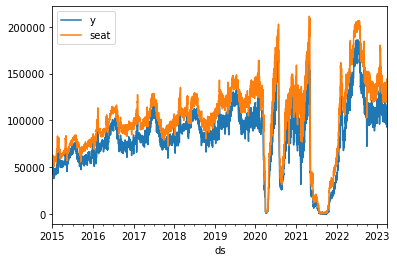

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('holidays2.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
# changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

## 2.1. Neural prophet

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,100),
        'n_changepoints':trial.suggest_int('n_changepoints',10,40),
        'changepoints_range': trial.suggest_float('changepoints_range',0.7,0.95),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 100),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,40),
        'n_lags':trial.suggest_int('n_lags',1,365),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,10),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3)
    }
    events_params_1 = {'regularization':trial.suggest_float('event1_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event1_mode',['multiplicative', 'additive'])}
    events_params_2 = {'regularization':trial.suggest_float('event2_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event2_mode',['multiplicative', 'additive'])}  
    lagged_regressor_params = {'regularization':trial.suggest_float('lagged_regularization',0,0.8),
                               'normalize':trial.suggest_categorical('lagged_normalize',['auto',True,False]),
                               'n_lags':trial.suggest_int('lagged_n_lags',1,365)}
    
    # Create the model
    optuna_model = NeuralProphet(**params, daily_seasonality = False, n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)  
    optuna_model.add_events(events = ['Lunar','Labor','Summer','new_year'], **events_params_2)
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [12]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-26 10:38:57,748] A new study created in memory with name: no-name-c1b92885-1913-486d-b5ab-cd24f79bf633


In [ ]:
study.optimize(objective, n_trials=300)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 157


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 10:42:38,296] Trial 0 finished with value: 71828.0 and parameters: {'trend_reg': 67.22818358452055, 'n_changepoints': 25, 'changepoints_range': 0.9063737935089741, 'seasonality_reg': 3.241494123867185, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 2, 'n_lags': 362, 'ar_reg': 0.06825733043655191, 'learning_rate': 7.698160488871209, 'num_hidden_layers': 2, 'event1_regularization': 0.07548778726699304, 'event1_mode': 'additive', 'event2_regularization': 0.07909080886916407, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.07489047463820207, 'lagged_normalize': 'auto', 'lagged_n_lags': 107}. Best is trial 0 with value: 71828.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 10:45:43,639] Trial 1 finished with value: 929324609.0 and parameters: {'trend_reg': 81.61441985635884, 'n_changepoints': 35, 'changepoints_range': 0.7553943429323944, 'seasonality_reg': 64.51898669017082, 'seasonality_mode': 'additive', 'yearly_seasonality': 13, 'weekly_seasonality': 6, 'n_lags': 78, 'ar_reg': 4.766561544558599, 'learning_rate': 0.7770607521635486, 'num_hidden_layers': 0, 'event1_regularization': 0.00131060053623282, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0335093255428607, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.03340682503539192, 'lagged_normalize': False, 'lagged_n_lags': 305}. Best is trial 0 with value: 71828.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 10:50:25,188] Trial 2 finished with value: 74542.0 and parameters: {'trend_reg': 25.263970383008104, 'n_changepoints': 40, 'changepoints_range': 0.8165595336774605, 'seasonality_reg': 26.482707868501716, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 37, 'n_lags': 343, 'ar_reg': 8.374935925752547, 'learning_rate': 4.32846056257588, 'num_hidden_layers': 2, 'event1_regularization': 0.17026879813435714, 'event1_mode': 'additive', 'event2_regularization': 0.12831402015469273, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5092960821691669, 'lagged_normalize': True, 'lagged_n_lags': 111}. Best is trial 0 with value: 71828.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 10:55:03,285] Trial 3 finished with value: 72734.0 and parameters: {'trend_reg': 71.85091947140288, 'n_changepoints': 39, 'changepoints_range': 0.7039455550882919, 'seasonality_reg': 31.328186329184636, 'seasonality_mode': 'additive', 'yearly_seasonality': 31, 'weekly_seasonality': 34, 'n_lags': 336, 'ar_reg': 1.5311845479779729, 'learning_rate': 4.700816178928225, 'num_hidden_layers': 2, 'event1_regularization': 0.10325058166133659, 'event1_mode': 'additive', 'event2_regularization': 0.04705330788557452, 'event2_mode': 'additive', 'lagged_regularization': 0.1949250432241333, 'lagged_normalize': 'auto', 'lagged_n_lags': 130}. Best is trial 0 with value: 71828.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 10:58:35,443] Trial 4 finished with value: 93850.0 and parameters: {'trend_reg': 10.347529588588547, 'n_changepoints': 19, 'changepoints_range': 0.7408022191173012, 'seasonality_reg': 23.359132047213123, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 26, 'n_lags': 282, 'ar_reg': 7.903317564120035, 'learning_rate': 5.26633680407094, 'num_hidden_layers': 1, 'event1_regularization': 0.19907297612171931, 'event1_mode': 'additive', 'event2_regularization': 0.030924026629826185, 'event2_mode': 'additive', 'lagged_regularization': 0.3798100502157203, 'lagged_normalize': 'auto', 'lagged_n_lags': 265}. Best is trial 0 with value: 71828.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_ori

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.861% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:02:56,617] Trial 5 finished with value: 74034.0 and parameters: {'trend_reg': 75.1356197915079, 'n_changepoints': 29, 'changepoints_range': 0.9255448527249526, 'seasonality_reg': 13.40029243751104, 'seasonality_mode': 'additive', 'yearly_seasonality': 30, 'weekly_seasonality': 21, 'n_lags': 282, 'ar_reg': 7.7642309131905165, 'learning_rate': 5.549085094106176, 'num_hidden_layers': 2, 'event1_regularization': 0.04982746843210631, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12358177987389328, 'event2_mode': 'additive', 'lagged_regularization': 0.5624746619691513, 'lagged_normalize': False, 'lagged_n_lags': 353}. Best is trial 0 with value: 71828.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_origin

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:06:15,779] Trial 6 finished with value: 51295.0 and parameters: {'trend_reg': 65.76190679343033, 'n_changepoints': 15, 'changepoints_range': 0.8704396387805615, 'seasonality_reg': 84.1221838516179, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 39, 'weekly_seasonality': 10, 'n_lags': 57, 'ar_reg': 6.3076622328963445, 'learning_rate': 0.3666573572043242, 'num_hidden_layers': 3, 'event1_regularization': 0.028560800053275482, 'event1_mode': 'additive', 'event2_regularization': 0.19265396892882455, 'event2_mode': 'additive', 'lagged_regularization': 0.7495088265435883, 'lagged_normalize': False, 'lagged_n_lags': 230}. Best is trial 6 with value: 51295.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_origi

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:10:56,612] Trial 7 finished with value: 68508.0 and parameters: {'trend_reg': 68.50236999159925, 'n_changepoints': 32, 'changepoints_range': 0.8787514087144688, 'seasonality_reg': 22.278261852440092, 'seasonality_mode': 'additive', 'yearly_seasonality': 39, 'weekly_seasonality': 30, 'n_lags': 61, 'ar_reg': 0.6650677541017858, 'learning_rate': 5.831013410319628, 'num_hidden_layers': 2, 'event1_regularization': 0.13487293525572117, 'event1_mode': 'additive', 'event2_regularization': 0.13980652517216646, 'event2_mode': 'additive', 'lagged_regularization': 0.3510608165904892, 'lagged_normalize': True, 'lagged_n_lags': 146}. Best is trial 6 with value: 51295.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_for

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:14:37,976] Trial 8 finished with value: 25852.0 and parameters: {'trend_reg': 81.74720442313338, 'n_changepoints': 11, 'changepoints_range': 0.8670291515071459, 'seasonality_reg': 1.5028488252181174, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 25, 'n_lags': 310, 'ar_reg': 4.363721251332012, 'learning_rate': 4.654395814247096, 'num_hidden_layers': 3, 'event1_regularization': 0.10192923113249969, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07248433342289813, 'event2_mode': 'additive', 'lagged_regularization': 0.62557599303809, 'lagged_normalize': False, 'lagged_n_lags': 317}. Best is trial 8 with value: 25852.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_o

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:17:49,339] Trial 9 finished with value: 68819.0 and parameters: {'trend_reg': 92.47803877492402, 'n_changepoints': 11, 'changepoints_range': 0.7984546778554349, 'seasonality_reg': 58.389952806766786, 'seasonality_mode': 'additive', 'yearly_seasonality': 40, 'weekly_seasonality': 7, 'n_lags': 122, 'ar_reg': 9.531252295056865, 'learning_rate': 4.2690059945262115, 'num_hidden_layers': 1, 'event1_regularization': 0.1742421286752273, 'event1_mode': 'additive', 'event2_regularization': 0.025338283997763944, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.32197827561336745, 'lagged_normalize': 'auto', 'lagged_n_lags': 154}. Best is trial 8 with value: 25852.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_ori

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.824% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:21:16,553] Trial 10 finished with value: 23538.0 and parameters: {'trend_reg': 41.51139158959476, 'n_changepoints': 20, 'changepoints_range': 0.8516245057079613, 'seasonality_reg': 44.180709896003656, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 17, 'n_lags': 204, 'ar_reg': 3.8265404332864237, 'learning_rate': 9.765475714305675, 'num_hidden_layers': 3, 'event1_regularization': 0.11044979470788181, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08100908828111249, 'event2_mode': 'additive', 'lagged_regularization': 0.740673548857193, 'lagged_normalize': False, 'lagged_n_lags': 13}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_i

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:24:47,461] Trial 11 finished with value: 25848.0 and parameters: {'trend_reg': 41.911049600366454, 'n_changepoints': 21, 'changepoints_range': 0.8527825927959215, 'seasonality_reg': 46.44570152248738, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 16, 'n_lags': 205, 'ar_reg': 3.884075077301077, 'learning_rate': 9.670750478822436, 'num_hidden_layers': 3, 'event1_regularization': 0.10955058537064417, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08025020997651208, 'event2_mode': 'additive', 'lagged_regularization': 0.7806650764295076, 'lagged_normalize': False, 'lagged_n_lags': 12}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_i

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:28:26,303] Trial 12 finished with value: 25531.0 and parameters: {'trend_reg': 40.184122174093986, 'n_changepoints': 22, 'changepoints_range': 0.8380778019823926, 'seasonality_reg': 43.00606202785154, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 15, 'n_lags': 205, 'ar_reg': 2.71143395491271, 'learning_rate': 9.943925114917594, 'num_hidden_layers': 3, 'event1_regularization': 0.13221268172725886, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09385460384292885, 'event2_mode': 'additive', 'lagged_regularization': 0.7990001123765474, 'lagged_normalize': False, 'lagged_n_lags': 12}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.823% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:32:20,114] Trial 13 finished with value: 24700.0 and parameters: {'trend_reg': 43.617492289299605, 'n_changepoints': 23, 'changepoints_range': 0.7896458826964348, 'seasonality_reg': 43.41968347965508, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 15, 'n_lags': 200, 'ar_reg': 2.4851945115097966, 'learning_rate': 9.56868673618828, 'num_hidden_layers': 3, 'event1_regularization': 0.13868218917659653, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10876925409235924, 'event2_mode': 'additive', 'lagged_regularization': 0.6570812329074857, 'lagged_normalize': False, 'lagged_n_lags': 18}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_i

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:35:44,708] Trial 14 finished with value: 25604.0 and parameters: {'trend_reg': 51.901022099958595, 'n_changepoints': 17, 'changepoints_range': 0.7847995941395838, 'seasonality_reg': 73.045841366975, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 15, 'n_lags': 145, 'ar_reg': 2.399459000351474, 'learning_rate': 8.063539436189533, 'num_hidden_layers': 3, 'event1_regularization': 0.13825704155594895, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16029589920545717, 'event2_mode': 'additive', 'lagged_regularization': 0.6390213041076475, 'lagged_normalize': False, 'lagged_n_lags': 55}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:39:01,893] Trial 15 finished with value: 542878092.0 and parameters: {'trend_reg': 25.515770530089274, 'n_changepoints': 26, 'changepoints_range': 0.7749037376640064, 'seasonality_reg': 96.57014162889536, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 20, 'n_lags': 245, 'ar_reg': 6.0879738549592, 'learning_rate': 8.221997756306658, 'num_hidden_layers': 0, 'event1_regularization': 0.07534353561543006, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11033779789546747, 'event2_mode': 'additive', 'lagged_regularization': 0.6807796998123302, 'lagged_normalize': False, 'lagged_n_lags': 66}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:42:51,353] Trial 16 finished with value: 42574.0 and parameters: {'trend_reg': 1.8079266754744125, 'n_changepoints': 25, 'changepoints_range': 0.9478624798276332, 'seasonality_reg': 38.424753533551154, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 11, 'n_lags': 157, 'ar_reg': 3.2617056300738527, 'learning_rate': 6.912819458629837, 'num_hidden_layers': 3, 'event1_regularization': 0.14510719784593176, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05935047144261814, 'event2_mode': 'additive', 'lagged_regularization': 0.4698940058847843, 'lagged_normalize': True, 'lagged_n_lags': 65}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:46:13,573] Trial 17 finished with value: 25761.0 and parameters: {'trend_reg': 52.259079520373554, 'n_changepoints': 15, 'changepoints_range': 0.8194715043499725, 'seasonality_reg': 54.62246062905366, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 21, 'n_lags': 235, 'ar_reg': 5.76517616650258, 'learning_rate': 2.322172319283338, 'num_hidden_layers': 1, 'event1_regularization': 0.07320768826545505, 'event1_mode': 'multiplicative', 'event2_regularization': 0.16017696207462206, 'event2_mode': 'additive', 'lagged_regularization': 0.6906684309685909, 'lagged_normalize': False, 'lagged_n_lags': 209}. Best is trial 10 with value: 23538.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_i

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:49:56,575] Trial 18 finished with value: 22656.0 and parameters: {'trend_reg': 27.782207467611798, 'n_changepoints': 28, 'changepoints_range': 0.717928939371322, 'seasonality_reg': 72.42255846446696, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 18, 'n_lags': 185, 'ar_reg': 1.9268056965490725, 'learning_rate': 9.174167334696424, 'num_hidden_layers': 3, 'event1_regularization': 0.11795215598429683, 'event1_mode': 'multiplicative', 'event2_regularization': 0.010969286110045329, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5684653788149955, 'lagged_normalize': False, 'lagged_n_lags': 37}. Best is trial 18 with value: 22656.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:53:47,166] Trial 19 finished with value: 20373.0 and parameters: {'trend_reg': 26.213820117778244, 'n_changepoints': 29, 'changepoints_range': 0.7035851265355051, 'seasonality_reg': 75.64374264487503, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 27, 'n_lags': 11, 'ar_reg': 1.3287101871144147, 'learning_rate': 8.784072930025818, 'num_hidden_layers': 2, 'event1_regularization': 0.11833060942652299, 'event1_mode': 'multiplicative', 'event2_regularization': 0.004154856135098056, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5636271858177312, 'lagged_normalize': True, 'lagged_n_lags': 53}. Best is trial 19 with value: 20373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 11:57:36,936] Trial 20 finished with value: 24794.0 and parameters: {'trend_reg': 23.765237088469537, 'n_changepoints': 30, 'changepoints_range': 0.70301230066416, 'seasonality_reg': 79.2234629738106, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 28, 'n_lags': 17, 'ar_reg': 1.1375273841970195, 'learning_rate': 6.941830775120341, 'num_hidden_layers': 2, 'event1_regularization': 0.16063862072033633, 'event1_mode': 'multiplicative', 'event2_regularization': 0.006068416068189003, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.45101542974698056, 'lagged_normalize': True, 'lagged_n_lags': 181}. Best is trial 19 with value: 20373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.792% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.792% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:01:32,053] Trial 21 finished with value: 21158.0 and parameters: {'trend_reg': 16.583471171252697, 'n_changepoints': 28, 'changepoints_range': 0.727639171944139, 'seasonality_reg': 68.46737448952479, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 32, 'n_lags': 115, 'ar_reg': 1.7638223148791303, 'learning_rate': 8.861027062106082, 'num_hidden_layers': 3, 'event1_regularization': 0.11423243635883937, 'event1_mode': 'multiplicative', 'event2_regularization': 0.013732864840515883, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5623363665634289, 'lagged_normalize': True, 'lagged_n_lags': 52}. Best is trial 19 with value: 20373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.787% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.787% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:05:41,693] Trial 22 finished with value: 21536.0 and parameters: {'trend_reg': 16.43169769400091, 'n_changepoints': 34, 'changepoints_range': 0.7287205228859268, 'seasonality_reg': 70.9060749032584, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 32, 'n_lags': 105, 'ar_reg': 1.604139873027535, 'learning_rate': 8.739871110674054, 'num_hidden_layers': 2, 'event1_regularization': 0.1185166558626118, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0018384315347369732, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5570364930071844, 'lagged_normalize': True, 'lagged_n_lags': 85}. Best is trial 19 with value: 20373.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.785% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.785% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:09:47,462] Trial 23 finished with value: 19944.0 and parameters: {'trend_reg': 13.578344021566616, 'n_changepoints': 34, 'changepoints_range': 0.73718758268976, 'seasonality_reg': 91.14682944893428, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 32, 'n_lags': 100, 'ar_reg': 0.18225907763368276, 'learning_rate': 8.720990673527469, 'num_hidden_layers': 1, 'event1_regularization': 0.08714257918204701, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0050007421402212685, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.5518404640850417, 'lagged_normalize': True, 'lagged_n_lags': 87}. Best is trial 23 with value: 19944.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.78% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.78% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:13:57,535] Trial 24 finished with value: 43499.0 and parameters: {'trend_reg': 3.8929503570651462, 'n_changepoints': 36, 'changepoints_range': 0.7535301651000904, 'seasonality_reg': 88.99583498526964, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 39, 'n_lags': 11, 'ar_reg': 0.12326744194397676, 'learning_rate': 6.8351843865056585, 'num_hidden_layers': 1, 'event1_regularization': 0.08718357008675183, 'event1_mode': 'multiplicative', 'event2_regularization': 0.019099106397450855, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.424539208706893, 'lagged_normalize': True, 'lagged_n_lags': 89}. Best is trial 23 with value: 19944.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.758% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.758% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:17:57,777] Trial 25 finished with value: 19534.0 and parameters: {'trend_reg': 15.398892117260058, 'n_changepoints': 32, 'changepoints_range': 0.7600274732786221, 'seasonality_reg': 93.62592547927144, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 35, 'n_lags': 23, 'ar_reg': 0.9542376655081766, 'learning_rate': 8.65970962368956, 'num_hidden_layers': 1, 'event1_regularization': 0.0506694956589778, 'event1_mode': 'multiplicative', 'event2_regularization': 0.046826947109822006, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.28631931507342506, 'lagged_normalize': True, 'lagged_n_lags': 48}. Best is trial 25 with value: 19534.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.784% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.784% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:22:04,742] Trial 26 finished with value: 66258.0 and parameters: {'trend_reg': 31.935342663379384, 'n_changepoints': 32, 'changepoints_range': 0.7669752596798088, 'seasonality_reg': 99.10602679156432, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_seasonality': 36, 'n_lags': 37, 'ar_reg': 0.7839478834252187, 'learning_rate': 3.426800157231476, 'num_hidden_layers': 1, 'event1_regularization': 0.05426808633472984, 'event1_mode': 'multiplicative', 'event2_regularization': 0.047970956956155254, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2861713513029124, 'lagged_normalize': True, 'lagged_n_lags': 98}. Best is trial 25 with value: 19534.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_i

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.811% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:25:41,989] Trial 27 finished with value: 1534894646.0 and parameters: {'trend_reg': 13.116727129229687, 'n_changepoints': 37, 'changepoints_range': 0.7442662823792254, 'seasonality_reg': 91.7414118498906, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 40, 'n_lags': 1, 'ar_reg': 0.7484144315977315, 'learning_rate': 6.32337043017554, 'num_hidden_layers': 0, 'event1_regularization': 0.04573305375555094, 'event1_mode': 'multiplicative', 'event2_regularization': 0.044693372791405145, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.17801010274307105, 'lagged_normalize': True, 'lagged_n_lags': 165}. Best is trial 25 with value: 19534.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:29:32,832] Trial 28 finished with value: 17029.0 and parameters: {'trend_reg': 7.980053003796851, 'n_changepoints': 32, 'changepoints_range': 0.7160876345516946, 'seasonality_reg': 80.96953481365955, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 24, 'n_lags': 83, 'ar_reg': 3.0572792795932173, 'learning_rate': 7.424857687287835, 'num_hidden_layers': 1, 'event1_regularization': 0.02214244835861716, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0005578744435932453, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2597264667887208, 'lagged_normalize': True, 'lagged_n_lags': 125}. Best is trial 28 with value: 17029.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:33:37,453] Trial 29 finished with value: 15219.0 and parameters: {'trend_reg': 7.823976276269305, 'n_changepoints': 33, 'changepoints_range': 0.7651032970850212, 'seasonality_reg': 83.53178535681006, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 25, 'n_lags': 86, 'ar_reg': 0.006821457480233217, 'learning_rate': 7.598266939209488, 'num_hidden_layers': 1, 'event1_regularization': 0.011462166120680631, 'event1_mode': 'multiplicative', 'event2_regularization': 0.063283278542485, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.23831968487161204, 'lagged_normalize': True, 'lagged_n_lags': 123}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:37:07,153] Trial 30 finished with value: 770991193.0 and parameters: {'trend_reg': 6.373634220263218, 'n_changepoints': 32, 'changepoints_range': 0.8031669838487593, 'seasonality_reg': 83.59737842840886, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 24, 'n_lags': 80, 'ar_reg': 2.987006233200493, 'learning_rate': 7.774947548285308, 'num_hidden_layers': 0, 'event1_regularization': 0.004113379773693519, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06228944156971839, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.22384422857655029, 'lagged_normalize': True, 'lagged_n_lags': 122}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.796% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:41:16,600] Trial 31 finished with value: 29322.0 and parameters: {'trend_reg': 0.01632022419956769, 'n_changepoints': 34, 'changepoints_range': 0.7620340275401265, 'seasonality_reg': 88.30950626539718, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 30, 'n_lags': 89, 'ar_reg': 0.19537757382038737, 'learning_rate': 7.368956445047556, 'num_hidden_layers': 1, 'event1_regularization': 0.027256152611101182, 'event1_mode': 'multiplicative', 'event2_regularization': 0.04125755940004973, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.1277373093348379, 'lagged_normalize': True, 'lagged_n_lags': 124}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:45:23,010] Trial 32 finished with value: 15791.0 and parameters: {'trend_reg': 17.891019244887534, 'n_changepoints': 38, 'changepoints_range': 0.7385646930419674, 'seasonality_reg': 93.7295525867893, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 23, 'n_lags': 43, 'ar_reg': 0.2793898517741466, 'learning_rate': 8.325208688580924, 'num_hidden_layers': 1, 'event1_regularization': 0.0174606918359919, 'event1_mode': 'multiplicative', 'event2_regularization': 0.025879973541658923, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2582324228824809, 'lagged_normalize': True, 'lagged_n_lags': 86}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.804% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:49:30,916] Trial 33 finished with value: 15750.0 and parameters: {'trend_reg': 18.435753817499744, 'n_changepoints': 37, 'changepoints_range': 0.7249268755313513, 'seasonality_reg': 62.69789424096856, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 23, 'n_lags': 46, 'ar_reg': 0.013459066724964133, 'learning_rate': 7.478894688781136, 'num_hidden_layers': 1, 'event1_regularization': 0.013966027249370174, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03132688733095898, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.27445752732588113, 'lagged_normalize': True, 'lagged_n_lags': 144}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.822% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:53:01,973] Trial 34 finished with value: 1360099974.0 and parameters: {'trend_reg': 8.802369232050344, 'n_changepoints': 38, 'changepoints_range': 0.7190203689818265, 'seasonality_reg': 61.416360318664026, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 23, 'n_lags': 47, 'ar_reg': 0.08420959381250451, 'learning_rate': 6.1776109146591995, 'num_hidden_layers': 0, 'event1_regularization': 0.009369298197427336, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03200103206281854, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.04598424077299573, 'lagged_normalize': True, 'lagged_n_lags': 198}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 12:57:14,448] Trial 35 finished with value: 47712.0 and parameters: {'trend_reg': 34.20131915871099, 'n_changepoints': 40, 'changepoints_range': 0.7153589331155519, 'seasonality_reg': 80.3548816751236, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 23, 'n_lags': 68, 'ar_reg': 5.271174995197464, 'learning_rate': 7.554382846000885, 'num_hidden_layers': 1, 'event1_regularization': 0.01841985392692277, 'event1_mode': 'additive', 'event2_regularization': 0.024441104901882556, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.11962029046905392, 'lagged_normalize': 'auto', 'lagged_n_lags': 141}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:01:22,516] Trial 36 finished with value: 16797.0 and parameters: {'trend_reg': 20.603833809576756, 'n_changepoints': 36, 'changepoints_range': 0.7410596092112162, 'seasonality_reg': 83.99899508618533, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 19, 'n_lags': 140, 'ar_reg': 1.940138872560757, 'learning_rate': 6.450423782462675, 'num_hidden_layers': 1, 'event1_regularization': 0.031571759918134254, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06032395889597398, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2398449384490866, 'lagged_normalize': True, 'lagged_n_lags': 108}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.815% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:05:28,078] Trial 37 finished with value: 76244.0 and parameters: {'trend_reg': 17.693532259488467, 'n_changepoints': 38, 'changepoints_range': 0.7474636356538475, 'seasonality_reg': 64.98432233330223, 'seasonality_mode': 'additive', 'yearly_seasonality': 28, 'weekly_seasonality': 2, 'n_lags': 144, 'ar_reg': 2.0630835741658635, 'learning_rate': 6.525441284566792, 'num_hidden_layers': 1, 'event1_regularization': 0.03600414882279482, 'event1_mode': 'additive', 'event2_regularization': 0.06515528358426026, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.15688601974930372, 'lagged_normalize': True, 'lagged_n_lags': 176}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_ori

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.832% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:08:55,176] Trial 38 finished with value: 23910.0 and parameters: {'trend_reg': 21.033123702230085, 'n_changepoints': 36, 'changepoints_range': 0.7753354336166725, 'seasonality_reg': 86.93080554949059, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 19, 'n_lags': 39, 'ar_reg': 0.602928295911944, 'learning_rate': 5.882139757532152, 'num_hidden_layers': 0, 'event1_regularization': 0.000318911257600649, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09383698882195134, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.37381693087605466, 'lagged_normalize': 'auto', 'lagged_n_lags': 231}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.801% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.801% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:13:30,269] Trial 39 finished with value: 34348.0 and parameters: {'trend_reg': 60.61369313527754, 'n_changepoints': 40, 'changepoints_range': 0.7345767239970977, 'seasonality_reg': 54.712117197481945, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 28, 'n_lags': 138, 'ar_reg': 1.3555991503087614, 'learning_rate': 5.077731772900176, 'num_hidden_layers': 1, 'event1_regularization': 0.013688293415835814, 'event1_mode': 'additive', 'event2_regularization': 0.035698916270377135, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.21592484853731764, 'lagged_normalize': True, 'lagged_n_lags': 100}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:17:40,510] Trial 40 finished with value: 69029.0 and parameters: {'trend_reg': 33.3382800529388, 'n_changepoints': 38, 'changepoints_range': 0.808363338630033, 'seasonality_reg': 9.60358508447036, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 12, 'n_lags': 172, 'ar_reg': 0.47614935214304, 'learning_rate': 8.069006589863802, 'num_hidden_layers': 2, 'event1_regularization': 0.039919083777747194, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0516824585994464, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.08166513448847121, 'lagged_normalize': True, 'lagged_n_lags': 159}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_or

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.79% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:21:42,363] Trial 41 finished with value: 17387.0 and parameters: {'trend_reg': 8.562779931834793, 'n_changepoints': 35, 'changepoints_range': 0.7208126641745808, 'seasonality_reg': 79.45362608457253, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 21, 'n_lags': 75, 'ar_reg': 1.1920921783674128, 'learning_rate': 7.3541572775432575, 'num_hidden_layers': 1, 'event1_regularization': 0.027726394710179625, 'event1_mode': 'multiplicative', 'event2_regularization': 0.021087963918635502, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.25154994469452585, 'lagged_normalize': True, 'lagged_n_lags': 111}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:25:49,939] Trial 42 finished with value: 19001.0 and parameters: {'trend_reg': 21.528470626787026, 'n_changepoints': 36, 'changepoints_range': 0.7473074443821784, 'seasonality_reg': 99.69795737321455, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 25, 'n_lags': 56, 'ar_reg': 3.4405624127615986, 'learning_rate': 7.278460845663573, 'num_hidden_layers': 1, 'event1_regularization': 0.06330398113212923, 'event1_mode': 'multiplicative', 'event2_regularization': 0.03286466450350861, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.3216283341773265, 'lagged_normalize': True, 'lagged_n_lags': 136}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:29:45,591] Trial 43 finished with value: 16036.0 and parameters: {'trend_reg': 9.37967136615347, 'n_changepoints': 33, 'changepoints_range': 0.7114589550355774, 'seasonality_reg': 83.01176582046601, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 22, 'n_lags': 122, 'ar_reg': 2.1950709255541465, 'learning_rate': 8.254744117234129, 'num_hidden_layers': 1, 'event1_regularization': 0.02119102149776145, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05617757424917801, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2660976281029478, 'lagged_normalize': True, 'lagged_n_lags': 114}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.799% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.799% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 71it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:33:59,596] Trial 44 finished with value: 17580.0 and parameters: {'trend_reg': 11.601403573957857, 'n_changepoints': 34, 'changepoints_range': 0.7334317110133437, 'seasonality_reg': 76.25406160988832, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 22, 'n_lags': 133, 'ar_reg': 2.149966718772991, 'learning_rate': 8.22850289036993, 'num_hidden_layers': 1, 'event1_regularization': 0.035518935868472365, 'event1_mode': 'multiplicative', 'event2_regularization': 0.06986397106194134, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.3233558511239947, 'lagged_normalize': True, 'lagged_n_lags': 110}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:38:17,053] Trial 45 finished with value: 15497.0 and parameters: {'trend_reg': 29.93144984553252, 'n_changepoints': 39, 'changepoints_range': 0.7079915937832513, 'seasonality_reg': 84.97003227665516, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 26, 'n_lags': 115, 'ar_reg': 4.616176710649917, 'learning_rate': 6.638379227663884, 'num_hidden_layers': 1, 'event1_regularization': 0.014592683597165437, 'event1_mode': 'multiplicative', 'event2_regularization': 0.057178572008120765, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.18610218312328702, 'lagged_normalize': 'auto', 'lagged_n_lags': 152}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.825% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:42:40,952] Trial 46 finished with value: 31038.0 and parameters: {'trend_reg': 29.60606234265332, 'n_changepoints': 39, 'changepoints_range': 0.7001642660654488, 'seasonality_reg': 65.1639039986025, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 26, 'n_lags': 98, 'ar_reg': 4.711472328418887, 'learning_rate': 9.274384440293602, 'num_hidden_layers': 2, 'event1_regularization': 0.013473073380252987, 'event1_mode': 'additive', 'event2_regularization': 0.0859652461517929, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.005771709679444292, 'lagged_normalize': 'auto', 'lagged_n_lags': 206}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:46:58,174] Trial 47 finished with value: 15470.0 and parameters: {'trend_reg': 4.758848598942819, 'n_changepoints': 40, 'changepoints_range': 0.8902163020985783, 'seasonality_reg': 94.87081769866845, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 29, 'n_lags': 118, 'ar_reg': 9.15714305286531, 'learning_rate': 5.404540044674901, 'num_hidden_layers': 1, 'event1_regularization': 0.008356456239785188, 'event1_mode': 'multiplicative', 'event2_regularization': 0.056243352644229784, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.16977611262770517, 'lagged_normalize': 'auto', 'lagged_n_lags': 152}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.841% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:50:34,617] Trial 48 finished with value: 155658.0 and parameters: {'trend_reg': 2.9725449322817283, 'n_changepoints': 40, 'changepoints_range': 0.9023508057915058, 'seasonality_reg': 95.14770928872801, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 30, 'n_lags': 30, 'ar_reg': 9.81029855667852, 'learning_rate': 5.418003658204436, 'num_hidden_layers': 0, 'event1_regularization': 0.008963461615663481, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07183391045701873, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.187483362569276, 'lagged_normalize': 'auto', 'lagged_n_lags': 265}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:54:50,597] Trial 49 finished with value: 19539.0 and parameters: {'trend_reg': 36.667395863419614, 'n_changepoints': 38, 'changepoints_range': 0.8434977383473461, 'seasonality_reg': 33.06227575630043, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 29, 'n_lags': 57, 'ar_reg': 7.226624819028722, 'learning_rate': 3.945325078221064, 'num_hidden_layers': 1, 'event1_regularization': 0.06432580932295773, 'event1_mode': 'multiplicative', 'event2_regularization': 0.040192462209858386, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.14129579447045743, 'lagged_normalize': 'auto', 'lagged_n_lags': 149}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 13:59:23,673] Trial 50 finished with value: 22233.0 and parameters: {'trend_reg': 5.331648008012339, 'n_changepoints': 39, 'changepoints_range': 0.8878062690303887, 'seasonality_reg': 86.96610477447422, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 26, 'n_lags': 161, 'ar_reg': 8.765008726046904, 'learning_rate': 5.545173773519028, 'num_hidden_layers': 1, 'event1_regularization': 0.0018889364563338751, 'event1_mode': 'additive', 'event2_regularization': 0.08422212689502627, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.09170272943506995, 'lagged_normalize': 'auto', 'lagged_n_lags': 193}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.814% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:03:31,671] Trial 51 finished with value: 15850.0 and parameters: {'trend_reg': 9.800394799566456, 'n_changepoints': 37, 'changepoints_range': 0.7114994006335522, 'seasonality_reg': 93.91067817013145, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 23, 'n_lags': 113, 'ar_reg': 6.627676281377898, 'learning_rate': 7.803021552143178, 'num_hidden_layers': 1, 'event1_regularization': 0.021266497309100404, 'event1_mode': 'multiplicative', 'event2_regularization': 0.054371600493778385, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2905754457429366, 'lagged_normalize': 'auto', 'lagged_n_lags': 172}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.813% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:07:45,960] Trial 52 finished with value: 15415.0 and parameters: {'trend_reg': 19.865737203363715, 'n_changepoints': 37, 'changepoints_range': 0.9277337935711077, 'seasonality_reg': 96.23853231707139, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 26, 'n_lags': 118, 'ar_reg': 7.291420380457393, 'learning_rate': 6.857984677016964, 'num_hidden_layers': 1, 'event1_regularization': 0.02043219718210413, 'event1_mode': 'multiplicative', 'event2_regularization': 0.05522017418708372, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.1998132887428628, 'lagged_normalize': 'auto', 'lagged_n_lags': 169}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.831% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:11:57,432] Trial 53 finished with value: 19287.0 and parameters: {'trend_reg': 18.448287497483605, 'n_changepoints': 37, 'changepoints_range': 0.927588273009364, 'seasonality_reg': 97.11932890254259, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 27, 'n_lags': 93, 'ar_reg': 8.639871627527137, 'learning_rate': 4.80022044904042, 'num_hidden_layers': 1, 'event1_regularization': 0.04105813954442376, 'event1_mode': 'multiplicative', 'event2_regularization': 0.027334612172777738, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.18805287954217917, 'lagged_normalize': 'auto', 'lagged_n_lags': 225}. Best is trial 29 with value: 15219.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:16:30,268] Trial 54 finished with value: 15119.0 and parameters: {'trend_reg': 28.120145284908403, 'n_changepoints': 40, 'changepoints_range': 0.948785414253, 'seasonality_reg': 91.05120170478764, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 25, 'n_lags': 67, 'ar_reg': 7.925081802526982, 'learning_rate': 6.895671699274748, 'num_hidden_layers': 1, 'event1_regularization': 0.013810120876808345, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0720092476321984, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.21562814579260092, 'lagged_normalize': 'auto', 'lagged_n_lags': 147}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.805% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:21:06,260] Trial 55 finished with value: 15414.0 and parameters: {'trend_reg': 47.96139062417619, 'n_changepoints': 40, 'changepoints_range': 0.9459417569599546, 'seasonality_reg': 88.97541757208478, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 33, 'n_lags': 124, 'ar_reg': 7.909679257995973, 'learning_rate': 5.772256529955334, 'num_hidden_layers': 1, 'event1_regularization': 0.009309078969583974, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07260956289958584, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.20810618118598426, 'lagged_normalize': 'auto', 'lagged_n_lags': 148}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:25:42,076] Trial 56 finished with value: 15718.0 and parameters: {'trend_reg': 48.926023588057774, 'n_changepoints': 40, 'changepoints_range': 0.9382135586164475, 'seasonality_reg': 90.7014950298732, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 34, 'n_lags': 126, 'ar_reg': 7.692252956562324, 'learning_rate': 5.715929821400947, 'num_hidden_layers': 1, 'event1_regularization': 0.008058849492573324, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07755367126095705, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.11535086379380495, 'lagged_normalize': 'auto', 'lagged_n_lags': 156}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.819% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:30:26,956] Trial 57 finished with value: 15757.0 and parameters: {'trend_reg': 58.08620662012119, 'n_changepoints': 39, 'changepoints_range': 0.9212629708104337, 'seasonality_reg': 76.86092779953057, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 31, 'n_lags': 155, 'ar_reg': 9.143247509573854, 'learning_rate': 6.817346948201125, 'num_hidden_layers': 2, 'event1_regularization': 0.027240589353743825, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10001767308095871, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.21331942097488638, 'lagged_normalize': 'auto', 'lagged_n_lags': 187}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:34:20,973] Trial 58 finished with value: 54908.0 and parameters: {'trend_reg': 45.25934676954489, 'n_changepoints': 40, 'changepoints_range': 0.9463014004720224, 'seasonality_reg': 85.9662179801839, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 28, 'n_lags': 180, 'ar_reg': 8.094297303392054, 'learning_rate': 6.026925374540129, 'num_hidden_layers': 0, 'event1_regularization': 0.0006583849599704006, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09164865673955885, 'event2_mode': 'additive', 'lagged_regularization': 0.16736079812802956, 'lagged_normalize': 'auto', 'lagged_n_lags': 169}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_d

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.8% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:38:31,621] Trial 59 finished with value: 25925.0 and parameters: {'trend_reg': 79.07292042582573, 'n_changepoints': 30, 'changepoints_range': 0.9098219065681974, 'seasonality_reg': 99.70147421798006, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 34, 'n_lags': 108, 'ar_reg': 7.267323324380578, 'learning_rate': 5.21976143507051, 'num_hidden_layers': 1, 'event1_regularization': 0.19463043688109957, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07629666105254461, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.20597612439852916, 'lagged_normalize': 'auto', 'lagged_n_lags': 134}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:43:01,146] Trial 60 finished with value: 19742.0 and parameters: {'trend_reg': 39.20891102386211, 'n_changepoints': 35, 'changepoints_range': 0.9368935086092134, 'seasonality_reg': 90.35982942101933, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'n_lags': 354, 'ar_reg': 9.253729480270087, 'learning_rate': 4.4150949213862125, 'num_hidden_layers': 2, 'event1_regularization': 0.05910262404546801, 'event1_mode': 'multiplicative', 'event2_regularization': 0.0677108198228313, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.049066874836573224, 'lagged_normalize': 'auto', 'lagged_n_lags': 362}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.808% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:47:35,236] Trial 61 finished with value: 15252.0 and parameters: {'trend_reg': 56.28509530318576, 'n_changepoints': 40, 'changepoints_range': 0.9376727775781737, 'seasonality_reg': 89.97622403643673, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 34, 'n_lags': 129, 'ar_reg': 7.609438057534533, 'learning_rate': 5.644378298631571, 'num_hidden_layers': 1, 'event1_regularization': 0.009540459710824272, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07930364152644852, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.10250135608304481, 'lagged_normalize': 'auto', 'lagged_n_lags': 155}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.807% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:52:01,546] Trial 62 finished with value: 15305.0 and parameters: {'trend_reg': 56.299943422499894, 'n_changepoints': 39, 'changepoints_range': 0.9092725244132426, 'seasonality_reg': 86.34415538479175, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 33, 'n_lags': 117, 'ar_reg': 6.722494213525066, 'learning_rate': 6.833328778324129, 'num_hidden_layers': 1, 'event1_regularization': 0.011526469151141234, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11130445200074064, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.14472568292678056, 'lagged_normalize': 'auto', 'lagged_n_lags': 154}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 14:56:20,498] Trial 63 finished with value: 15635.0 and parameters: {'trend_reg': 57.21393111981354, 'n_changepoints': 40, 'changepoints_range': 0.9144568447133766, 'seasonality_reg': 96.25232192172078, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 33, 'n_lags': 73, 'ar_reg': 6.705190346125594, 'learning_rate': 7.021629937353782, 'num_hidden_layers': 1, 'event1_regularization': 0.007840012725137345, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11489284570339837, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.11078791575777, 'lagged_normalize': 'auto', 'lagged_n_lags': 161}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.828% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:00:49,752] Trial 64 finished with value: 15730.0 and parameters: {'trend_reg': 64.4526434079248, 'n_changepoints': 38, 'changepoints_range': 0.8873249455909817, 'seasonality_reg': 91.67359086725175, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 36, 'n_lags': 125, 'ar_reg': 7.472527301278657, 'learning_rate': 3.8503875638824567, 'num_hidden_layers': 1, 'event1_regularization': 0.02326603483876382, 'event1_mode': 'multiplicative', 'event2_regularization': 0.10578492308988502, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.06625034903121739, 'lagged_normalize': 'auto', 'lagged_n_lags': 217}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:05:09,702] Trial 65 finished with value: 17211.0 and parameters: {'trend_reg': 68.61196583043474, 'n_changepoints': 35, 'changepoints_range': 0.9311662830341281, 'seasonality_reg': 89.80871768007378, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 31, 'n_lags': 93, 'ar_reg': 8.168050713620115, 'learning_rate': 6.0893797270999315, 'num_hidden_layers': 1, 'event1_regularization': 0.033442424853890665, 'event1_mode': 'multiplicative', 'event2_regularization': 0.13507272942696966, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.1519947128114683, 'lagged_normalize': 'auto', 'lagged_n_lags': 183}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.806% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 70it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:09:41,660] Trial 66 finished with value: 19407.0 and parameters: {'trend_reg': 96.01130750391683, 'n_changepoints': 39, 'changepoints_range': 0.9021497802444369, 'seasonality_reg': 73.85177853177188, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 37, 'n_lags': 150, 'ar_reg': 6.997015390645401, 'learning_rate': 2.934592291186152, 'num_hidden_layers': 1, 'event1_regularization': 0.04495718493525243, 'event1_mode': 'multiplicative', 'event2_regularization': 0.11799157297100582, 'event2_mode': 'additive', 'lagged_regularization': 0.14193694658418124, 'lagged_normalize': 'auto', 'lagged_n_lags': 132}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.838% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 67it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:13:46,210] Trial 67 finished with value: 39007.0 and parameters: {'trend_reg': 47.16111443096949, 'n_changepoints': 24, 'changepoints_range': 0.9419908400692582, 'seasonality_reg': 68.38410665040034, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'weekly_seasonality': 33, 'n_lags': 169, 'ar_reg': 8.417617769125592, 'learning_rate': 4.7690913744260115, 'num_hidden_layers': 1, 'event1_regularization': 0.006250416983264283, 'event1_mode': 'multiplicative', 'event2_regularization': 0.08690537384707445, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.23695631768187067, 'lagged_normalize': 'auto', 'lagged_n_lags': 253}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:18:02,979] Trial 68 finished with value: 15321.0 and parameters: {'trend_reg': 52.912491143772485, 'n_changepoints': 37, 'changepoints_range': 0.9189958200098273, 'seasonality_reg': 95.04594479285453, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 29, 'n_lags': 313, 'ar_reg': 5.9016003051469434, 'learning_rate': 7.091256249596728, 'num_hidden_layers': 1, 'event1_regularization': 0.017573537154564143, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09982225000532458, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.007747695761280052, 'lagged_normalize': 'auto', 'lagged_n_lags': 306}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:21:30,096] Trial 69 finished with value: 18455.0 and parameters: {'trend_reg': 54.256897846811405, 'n_changepoints': 10, 'changepoints_range': 0.9492065933378266, 'seasonality_reg': 88.12131169785093, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 39, 'n_lags': 309, 'ar_reg': 5.840319112497813, 'learning_rate': 7.130849819351648, 'num_hidden_layers': 1, 'event1_regularization': 0.028714299719622645, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1027805218801456, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.0893688671330402, 'lagged_normalize': 'auto', 'lagged_n_lags': 302}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.854% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:25:08,644] Trial 70 finished with value: 137754.0 and parameters: {'trend_reg': 61.234067094925955, 'n_changepoints': 37, 'changepoints_range': 0.9206726906043546, 'seasonality_reg': 82.21289584593879, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 35, 'n_lags': 264, 'ar_reg': 6.420045576942781, 'learning_rate': 1.6074868930113748, 'num_hidden_layers': 0, 'event1_regularization': 0.017706844464938837, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09027447486169984, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.057331157796119914, 'lagged_normalize': 'auto', 'lagged_n_lags': 322}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_util

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.829% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 68it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:29:27,051] Trial 71 finished with value: 15741.0 and parameters: {'trend_reg': 75.32758762554928, 'n_changepoints': 39, 'changepoints_range': 0.8940849718804452, 'seasonality_reg': 98.95919056748936, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 31, 'n_lags': 220, 'ar_reg': 5.4384180595475415, 'learning_rate': 6.308031248544374, 'num_hidden_layers': 1, 'event1_regularization': 0.009936257961808002, 'event1_mode': 'multiplicative', 'event2_regularization': 0.07662868110284127, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.01459679507042692, 'lagged_normalize': 'auto', 'lagged_n_lags': 146}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:33:34,500] Trial 72 finished with value: 15709.0 and parameters: {'trend_reg': 50.56177445495065, 'n_changepoints': 36, 'changepoints_range': 0.8727328132076303, 'seasonality_reg': 94.31435868057763, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 28, 'n_lags': 325, 'ar_reg': 7.8058787719187634, 'learning_rate': 5.690267448721619, 'num_hidden_layers': 1, 'event1_regularization': 0.023216332647799674, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1237376250295069, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.02427839707901802, 'lagged_normalize': 'auto', 'lagged_n_lags': 120}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.812% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:37:53,364] Trial 73 finished with value: 16036.0 and parameters: {'trend_reg': 56.33173357468903, 'n_changepoints': 38, 'changepoints_range': 0.9336089141280571, 'seasonality_reg': 92.20021187687306, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 29, 'n_lags': 105, 'ar_reg': 7.024682215852895, 'learning_rate': 6.703053284144075, 'num_hidden_layers': 1, 'event1_regularization': 0.0003859972612423549, 'event1_mode': 'multiplicative', 'event2_regularization': 0.09724641188235378, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.104724416490726, 'lagged_normalize': 'auto', 'lagged_n_lags': 168}. Best is trial 54 with value: 15119.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:42:19,830] Trial 74 finished with value: 14978.0 and parameters: {'trend_reg': 52.87615009354765, 'n_changepoints': 40, 'changepoints_range': 0.9163253691359796, 'seasonality_reg': 96.52142735351879, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 29, 'n_lags': 130, 'ar_reg': 6.122446153024846, 'learning_rate': 5.281333864022055, 'num_hidden_layers': 1, 'event1_regularization': 0.0127613715610101, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15418312812269624, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.16037009368926156, 'lagged_normalize': 'auto', 'lagged_n_lags': 194}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:46:41,704] Trial 75 finished with value: 15359.0 and parameters: {'trend_reg': 53.31657634165095, 'n_changepoints': 37, 'changepoints_range': 0.916919505068336, 'seasonality_reg': 96.63906097875007, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 33, 'n_lags': 86, 'ar_reg': 6.174783804801265, 'learning_rate': 7.843429479556638, 'num_hidden_layers': 1, 'event1_regularization': 0.01481969785880554, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1708342441425113, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.3056735161945441, 'lagged_normalize': 'auto', 'lagged_n_lags': 72}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_d

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.776% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:50:01,514] Trial 76 finished with value: 39131.0 and parameters: {'trend_reg': 53.99593004093558, 'n_changepoints': 18, 'changepoints_range': 0.913480399881787, 'seasonality_reg': 78.4654041445883, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 33, 'n_lags': 82, 'ar_reg': 6.1262514714722, 'learning_rate': 7.7178547776275375, 'num_hidden_layers': 1, 'event1_regularization': 0.015104686461205726, 'event1_mode': 'additive', 'event2_regularization': 0.183920577968555, 'event2_mode': 'additive', 'lagged_regularization': 0.3079464663114728, 'lagged_normalize': False, 'lagged_n_lags': 66}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.821% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 69it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:53:51,667] Trial 77 finished with value: 18164.0 and parameters: {'trend_reg': 63.29894486142334, 'n_changepoints': 26, 'changepoints_range': 0.9200636973739095, 'seasonality_reg': 86.14062622328751, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 32, 'n_lags': 193, 'ar_reg': 5.628799363265719, 'learning_rate': 6.3640638372716225, 'num_hidden_layers': 1, 'event1_regularization': 0.03856930413650757, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15253204362718906, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.35347692927024343, 'lagged_normalize': 'auto', 'lagged_n_lags': 77}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.767% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.767% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 73it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 15:56:59,711] Trial 78 finished with value: 20448.0 and parameters: {'trend_reg': 67.56168903483189, 'n_changepoints': 13, 'changepoints_range': 0.9405373370880934, 'seasonality_reg': 88.84021037844148, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 30, 'n_lags': 64, 'ar_reg': 5.1403147222301575, 'learning_rate': 5.88760779313713, 'num_hidden_layers': 2, 'event1_regularization': 0.03131948028538048, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18076645636435723, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.13269256517224085, 'lagged_normalize': 'auto', 'lagged_n_lags': 30}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.844% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:01:05,328] Trial 79 finished with value: 71481.0 and parameters: {'trend_reg': 43.71337401160092, 'n_changepoints': 33, 'changepoints_range': 0.8612381367537787, 'seasonality_reg': 97.26091255139865, 'seasonality_mode': 'additive', 'yearly_seasonality': 17, 'weekly_seasonality': 35, 'n_lags': 130, 'ar_reg': 4.163779002978546, 'learning_rate': 7.866736653539187, 'num_hidden_layers': 1, 'event1_regularization': 0.025373581529476164, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1526769527026027, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.22990608006320962, 'lagged_normalize': 'auto', 'lagged_n_lags': 278}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 72it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:05:24,612] Trial 80 finished with value: 22172.0 and parameters: {'trend_reg': 47.54808044773473, 'n_changepoints': 39, 'changepoints_range': 0.904049821469888, 'seasonality_reg': 82.79464303201502, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 14, 'weekly_seasonality': 32, 'n_lags': 86, 'ar_reg': 6.0178758219048305, 'learning_rate': 4.9485004028382145, 'num_hidden_layers': 1, 'event1_regularization': 0.08854176123180235, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1834940111064287, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.39494907807221313, 'lagged_normalize': 'auto', 'lagged_n_lags': 95}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.857% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:09:32,614] Trial 81 finished with value: 15095.0 and parameters: {'trend_reg': 60.346358439098665, 'n_changepoints': 37, 'changepoints_range': 0.9309958155753756, 'seasonality_reg': 92.8519713440768, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 25, 'n_lags': 102, 'ar_reg': 6.427445359299494, 'learning_rate': 7.036851131045929, 'num_hidden_layers': 1, 'event1_regularization': 0.01865852403401623, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1957680712782476, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.2090666841181035, 'lagged_normalize': 'auto', 'lagged_n_lags': 336}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.862% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:13:38,499] Trial 82 finished with value: 15306.0 and parameters: {'trend_reg': 59.61660469152902, 'n_changepoints': 36, 'changepoints_range': 0.9236615197686662, 'seasonality_reg': 93.04040134859063, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 27, 'n_lags': 101, 'ar_reg': 6.5554379123445115, 'learning_rate': 7.181188543257279, 'num_hidden_layers': 1, 'event1_regularization': 0.011549458693455443, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19696908708155547, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.16304035750521034, 'lagged_normalize': 'auto', 'lagged_n_lags': 359}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:17:50,016] Trial 83 finished with value: 15197.0 and parameters: {'trend_reg': 59.847328544676756, 'n_changepoints': 35, 'changepoints_range': 0.8278061776829976, 'seasonality_reg': 93.05812518089058, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 25, 'n_lags': 100, 'ar_reg': 6.443394024999258, 'learning_rate': 8.486051878296438, 'num_hidden_layers': 1, 'event1_regularization': 0.013487223918131584, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19684003155416485, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.16450946569551206, 'lagged_normalize': 'auto', 'lagged_n_lags': 337}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.r

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:22:07,674] Trial 84 finished with value: 15424.0 and parameters: {'trend_reg': 59.95108257273353, 'n_changepoints': 35, 'changepoints_range': 0.8969998063265782, 'seasonality_reg': 92.73612764257052, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 25, 'n_lags': 106, 'ar_reg': 6.680118596788719, 'learning_rate': 7.215174138720001, 'num_hidden_layers': 1, 'event1_regularization': 0.012222691741375013, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19952969985888538, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.16368555148895683, 'lagged_normalize': 'auto', 'lagged_n_lags': 339}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.859% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:26:16,019] Trial 85 finished with value: 15927.0 and parameters: {'trend_reg': 55.84438244328152, 'n_changepoints': 33, 'changepoints_range': 0.8294250437518618, 'seasonality_reg': 85.99067429604489, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 27, 'n_lags': 98, 'ar_reg': 6.364583844075503, 'learning_rate': 8.434406589113639, 'num_hidden_layers': 1, 'event1_regularization': 0.004749894504920239, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19658439601527075, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.08568144331174972, 'lagged_normalize': 'auto', 'lagged_n_lags': 343}. Best is trial 74 with value: 14978.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:30:20,920] Trial 86 finished with value: 14727.0 and parameters: {'trend_reg': 69.33975180058466, 'n_changepoints': 36, 'changepoints_range': 0.9253275894752124, 'seasonality_reg': 92.71684796654475, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 25, 'n_lags': 72, 'ar_reg': 5.650492304387038, 'learning_rate': 8.994205855713977, 'num_hidden_layers': 1, 'event1_regularization': 0.017845217910056225, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1922900145374671, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.03834202409353608, 'lagged_normalize': False, 'lagged_n_lags': 328}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.855% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:34:42,378] Trial 87 finished with value: 45814.0 and parameters: {'trend_reg': 71.62437559353788, 'n_changepoints': 36, 'changepoints_range': 0.7870351639406856, 'seasonality_reg': 91.94337316844471, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 12, 'weekly_seasonality': 24, 'n_lags': 54, 'ar_reg': 6.975780911478711, 'learning_rate': 9.16855051677533, 'num_hidden_layers': 1, 'event1_regularization': 0.15051470956087892, 'event1_mode': 'additive', 'event2_regularization': 0.18974008224073932, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.1291280394490305, 'lagged_normalize': False, 'lagged_n_lags': 327}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 63it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:39:17,841] Trial 88 finished with value: 16182.0 and parameters: {'trend_reg': 62.42344640289033, 'n_changepoints': 35, 'changepoints_range': 0.9261190000523507, 'seasonality_reg': 81.03525821133617, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'weekly_seasonality': 20, 'n_lags': 72, 'ar_reg': 5.669408578808551, 'learning_rate': 8.523868091514792, 'num_hidden_layers': 1, 'event1_regularization': 0.0036644986420569965, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1741233854005232, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.06932382874063203, 'lagged_normalize': False, 'lagged_n_lags': 365}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.858% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:43:29,949] Trial 89 finished with value: 16076.0 and parameters: {'trend_reg': 70.2330708876097, 'n_changepoints': 34, 'changepoints_range': 0.9327455795744661, 'seasonality_reg': 24.013625603075443, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 25, 'n_lags': 135, 'ar_reg': 4.933583333717452, 'learning_rate': 7.601162809725659, 'num_hidden_layers': 1, 'event1_regularization': 0.03029225097303974, 'event1_mode': 'multiplicative', 'event2_regularization': 0.19222652217180589, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.1522806622519334, 'lagged_normalize': False, 'lagged_n_lags': 340}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.86% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.86% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:47:35,732] Trial 90 finished with value: 23197.0 and parameters: {'trend_reg': 65.05585093614378, 'n_changepoints': 38, 'changepoints_range': 0.8791542284464838, 'seasonality_reg': 99.74820666884547, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 22, 'n_lags': 98, 'ar_reg': 6.564664044535524, 'learning_rate': 9.80205711218309, 'num_hidden_layers': 1, 'event1_regularization': 0.12902751217898267, 'event1_mode': 'multiplicative', 'event2_regularization': 0.18744896248165352, 'event2_mode': 'additive', 'lagged_regularization': 0.18160759244852254, 'lagged_normalize': False, 'lagged_n_lags': 351}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:51:58,721] Trial 91 finished with value: 15074.0 and parameters: {'trend_reg': 58.48996864116697, 'n_changepoints': 36, 'changepoints_range': 0.911170502465491, 'seasonality_reg': 93.85320730686684, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 27, 'n_lags': 288, 'ar_reg': 5.379629926214079, 'learning_rate': 8.998738167853363, 'num_hidden_layers': 1, 'event1_regularization': 0.018754330447311868, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17574683758659354, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.033696171108760026, 'lagged_normalize': 'auto', 'lagged_n_lags': 308}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.re

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 16:56:09,913] Trial 92 finished with value: 15094.0 and parameters: {'trend_reg': 58.577962795049444, 'n_changepoints': 36, 'changepoints_range': 0.9109704839152092, 'seasonality_reg': 93.06055434680987, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 24, 'n_lags': 67, 'ar_reg': 7.493529745249999, 'learning_rate': 9.062864115330116, 'num_hidden_layers': 1, 'event1_regularization': 0.01935251859341275, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1762374492599887, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.031096948937379038, 'lagged_normalize': False, 'lagged_n_lags': 310}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:00:24,438] Trial 93 finished with value: 15193.0 and parameters: {'trend_reg': 50.90438321520438, 'n_changepoints': 34, 'changepoints_range': 0.9104047044082266, 'seasonality_reg': 84.62795586639015, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 24, 'n_lags': 67, 'ar_reg': 7.638194837699935, 'learning_rate': 8.998284360899088, 'num_hidden_layers': 1, 'event1_regularization': 0.019678857774827682, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1757480141258704, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.03891022953047259, 'lagged_normalize': False, 'lagged_n_lags': 297}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:04:43,705] Trial 94 finished with value: 15232.0 and parameters: {'trend_reg': 50.66531116974117, 'n_changepoints': 31, 'changepoints_range': 0.9094832567093355, 'seasonality_reg': 49.22868117561584, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 25, 'n_lags': 48, 'ar_reg': 7.611087293981394, 'learning_rate': 8.911019057698256, 'num_hidden_layers': 1, 'event1_regularization': 0.021184268829639433, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17538741522565085, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.02969653496127561, 'lagged_normalize': False, 'lagged_n_lags': 296}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.848% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 66it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:09:04,655] Trial 95 finished with value: 15426.0 and parameters: {'trend_reg': 50.362162586283155, 'n_changepoints': 33, 'changepoints_range': 0.8967486045733858, 'seasonality_reg': 52.35360292649743, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 24, 'n_lags': 64, 'ar_reg': 5.466839446325215, 'learning_rate': 8.993903284059282, 'num_hidden_layers': 1, 'event1_regularization': 0.019588710531791478, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17342968972014774, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.03147463575533719, 'lagged_normalize': False, 'lagged_n_lags': 291}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.856% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 64it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:13:16,608] Trial 96 finished with value: 72309.0 and parameters: {'trend_reg': 75.09921391899226, 'n_changepoints': 31, 'changepoints_range': 0.9074153034114574, 'seasonality_reg': 37.90737038567577, 'seasonality_mode': 'additive', 'yearly_seasonality': 21, 'weekly_seasonality': 24, 'n_lags': 31, 'ar_reg': 7.472503799920037, 'learning_rate': 9.456271511295588, 'num_hidden_layers': 1, 'event1_regularization': 0.025127147624929593, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1675711750238326, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.0420635475132265, 'lagged_normalize': False, 'lagged_n_lags': 330}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.852% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:17:36,464] Trial 97 finished with value: 19247.0 and parameters: {'trend_reg': 66.71863451212295, 'n_changepoints': 31, 'changepoints_range': 0.878087546719994, 'seasonality_reg': 46.20231519257932, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 21, 'n_lags': 76, 'ar_reg': 4.471096937504479, 'learning_rate': 9.963821748094459, 'num_hidden_layers': 1, 'event1_regularization': 0.049556603936135285, 'event1_mode': 'multiplicative', 'event2_regularization': 0.17979451598453872, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.03754872245339882, 'lagged_normalize': False, 'lagged_n_lags': 312}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retur

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.849% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:22:11,373] Trial 98 finished with value: 18635.0 and parameters: {'trend_reg': 58.638525638916185, 'n_changepoints': 34, 'changepoints_range': 0.8124869708812923, 'seasonality_reg': 56.53031251733517, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 25, 'n_lags': 52, 'ar_reg': 8.185122683426426, 'learning_rate': 8.953970740848995, 'num_hidden_layers': 1, 'event1_regularization': 0.03959705549005559, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1636586927289323, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.0015762210301242252, 'lagged_normalize': False, 'lagged_n_lags': 296}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.ret

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.853% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 65it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-26 17:26:32,946] Trial 99 finished with value: 18667.0 and parameters: {'trend_reg': 40.37917394556037, 'n_changepoints': 31, 'changepoints_range': 0.9137629186825101, 'seasonality_reg': 41.130734834147226, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 22, 'n_lags': 47, 'ar_reg': 6.892151765429228, 'learning_rate': 9.424158908177594, 'num_hidden_layers': 1, 'event1_regularization': 0.04459302521743709, 'event1_mode': 'multiplicative', 'event2_regularization': 0.15503632571865872, 'event2_mode': 'multiplicative', 'lagged_regularization': 0.06658601291055961, 'lagged_normalize': False, 'lagged_n_lags': 316}. Best is trial 86 with value: 14727.0.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.retu

Training: 0it [00:00, ?it/s]

In [ ]:
params = study.best_trial.params
# params =  {'trend_reg': 91.16651671120684, 'seasonality_reg': 80.38723216541241, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 37, 'n_lags': 208, 'ar_reg': 0.7595704262878455, 'learning_rate': 8.0435868694987, 'num_hidden_layers': 2, 'loss_func': 'MAE', 'event1_regularization': 0.0530615775463566, 'event1_mode': 'multiplicative', 'event2_regularization': 0.1623471948872433, 'event2_mode': 'additive', 'lagged_regularization': 0.2554626397766526, 'lagged_normalize': False, 'lagged_n_lags': 219}

In [ ]:
lagged_params = {key: params[key] for key in ['lagged_regularization','lagged_normalize','lagged_n_lags']}
events_params_1 = {key: params[key] for key in ['event1_regularization','event1_mode']}
events_params_2 = {key: params[key] for key in ['event2_regularization','event2_mode']}
main_params = {key: params[key] for key in ['trend_reg','seasonality_reg','seasonality_mode',
                                            'yearly_seasonality','n_lags','ar_reg','learning_rate','num_hidden_layers','loss_func']}

In [ ]:
lagged_params = dict(zip(['regularization','normalize','n_lags'], list(lagged_params.values())))
events_params_1 = dict(zip(['regularization','mode'], list(events_params_1.values())))
events_params_2 = dict(zip(['regularization','mode'], list(events_params_2.values())))

In [ ]:
set_random_seed(99)

In [ ]:
m = NeuralProphet(**main_params, daily_seasonality = False, n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)
m.add_events(events = ['Labor','Lunar','Summer','new_year'], **events_params_2)
m.add_lagged_regressor('seat', **lagged_params)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

In [ ]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

In [ ]:
fig_param = m.plot_parameters()

In [ ]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

In [ ]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-12-31')]

In [ ]:
forecast = m.predict(future, decompose = True)
fig = m.plot(forecast)

In [ ]:
#Consolidate forecast result
for i in forecast.filter(regex= ('yhat')).columns[1:]:
    forecast['yhat1'].update(forecast.pop(i))
for i in forecast.filter(regex= ('ar\d')).columns[1:]:
    forecast['ar1'].update(forecast.pop(i))
for i in forecast.filter(regex= ('lagged_regressor_seat')).columns[1:]:
    forecast['lagged_regressor_seat1'].update(forecast.pop(i))

In [ ]:
forecast.update(forecast[['ds','yhat1']].merge(dom, 'left','ds'))

In [ ]:
forecast

In [ ]:
forecast.to_excel('neural_prophet_result.xlsx')